# Regresyon 
Bir konut mülkünün satış fiyatını tahmin etmek, mülkün yaşı, yerel olanakların mevcudiyeti ve konum dahil olmak üzere bir dizi faktöre bağlıdır.

Bu yarışmada, özelliklerine dayalı olarak bir mülkün birim başına fiyatını tahmin etmek için bir gayrimenkul satış işlemleri veri kümesi kullanacaksınız. Bu verilerdeki birim fiyat, 3,3 metrekarelik bir birim ölçüsüne dayanmaktadır.

## Verilerin inceleme

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("real_estate.csv")
df.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


Veriler aşağıdaki değişkenlerden oluşur:

* **transaction_date -** işlem tarihi (örneğin, 2013.250=2013 Mart, 2013.500=2013 Haziran vb.)
* **house_age -** evin yaşı (yıl olarak)
* **transit_distance -** en yakın hafif raylı sistem istasyonuna olan mesafe (metre cinsinden)
* **local_convenience_stores -** yürüme mesafesindeki marketlerin sayısı
* **latitude -** coğrafi koordinat, enlem
* **longitude -** coğrafi koordinat, boylam
* **price_per_unit -** evin birim alan fiyatı (3,3 metrekare)

## Regresyon Modeli Eğitme
Buradaki zorluk, verileri araştırmak ve hazırlamak, price_per_unit etiketini tahmin etmeye yardımcı olacak tahmine dayalı özellikleri belirlemek ve bir test veri alt kümesine göre değerlendirildiğinde elde edebileceğiniz en düşük Kök Ortalama Kare Hatayı (RMSE) (7'den az olmalıdır) elde eden bir regresyon modeli eğitmektir.

### Etiket dağılımı

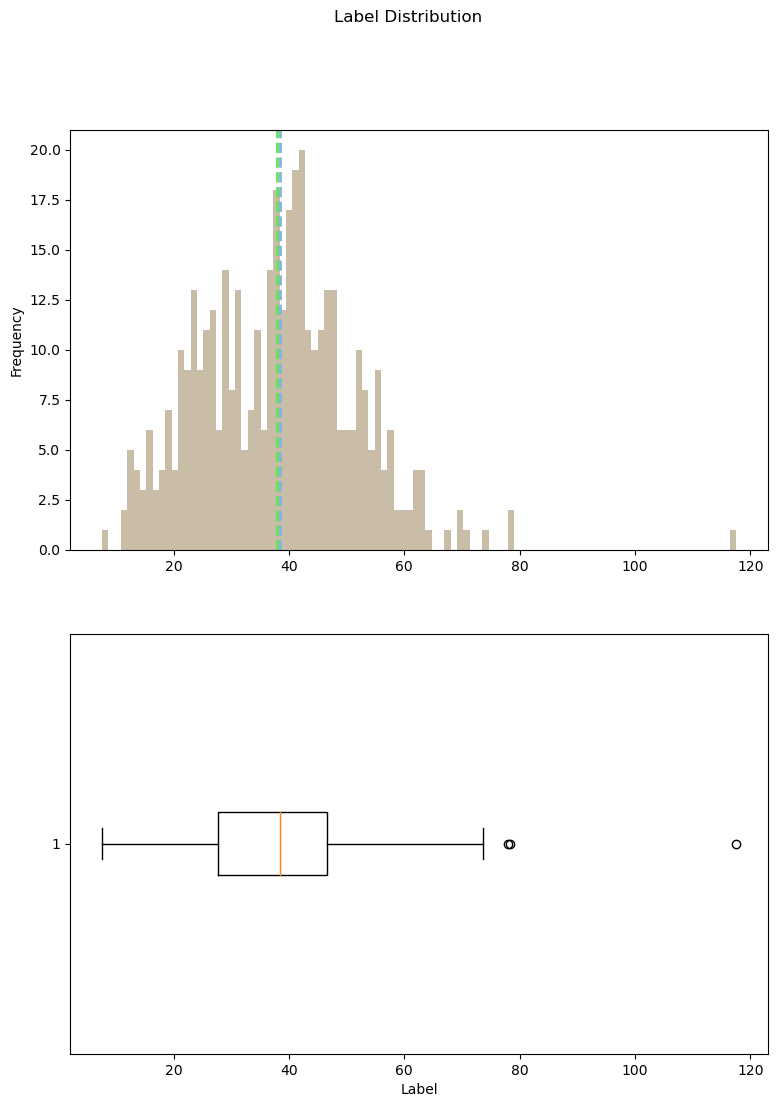

In [3]:
label = df[df.columns[-1]]

fig, ax = plt.subplots(2, 1, figsize=(9,12))

ax[0].hist(label, bins=100, color="#c9bda8")
ax[0].set_ylabel("Frequency")

ax[0].axvline(label.mean(), color="#61e652", linestyle="--", linewidth=2)
ax[0].axvline(label.median(), color="#84b1e6", linestyle="--", linewidth=2)

ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Label')

fig.suptitle("Label Distribution")

fig.show()

### Aykırı değerler

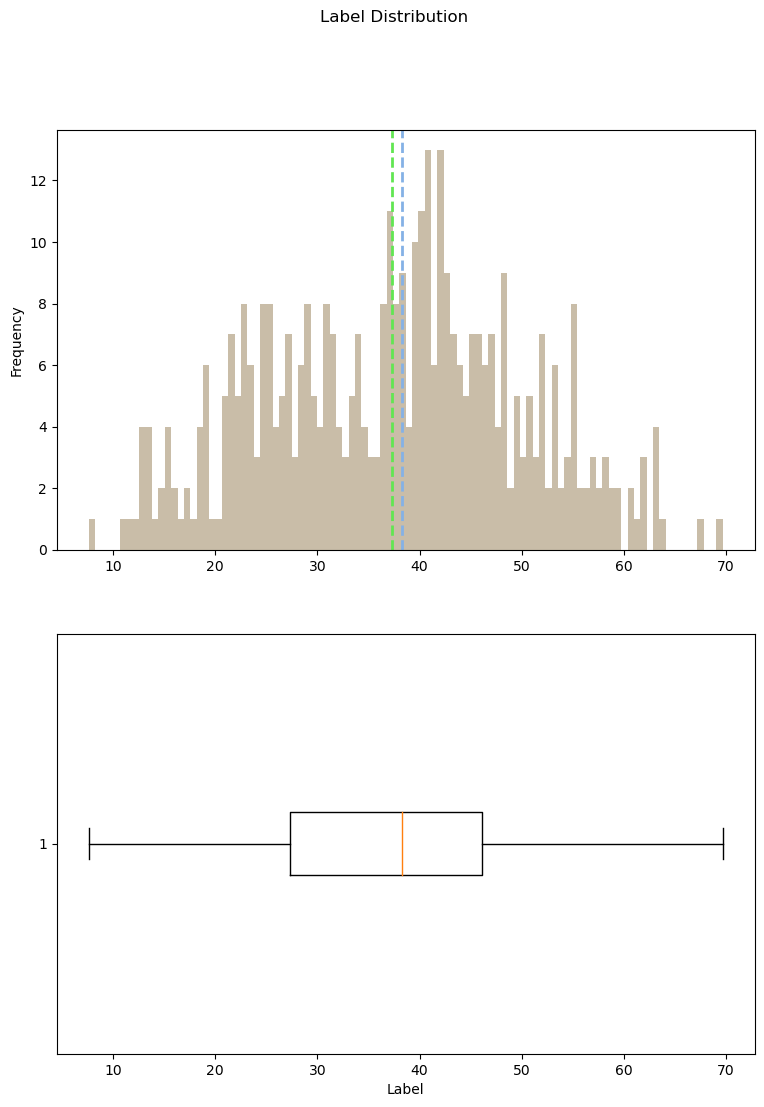

In [4]:
df = df[df["price_per_unit"] < 70]

label = df[df.columns[-1]]

fig, ax = plt.subplots(2, 1, figsize=(9,12))

ax[0].hist(label, bins=100, color="#c9bda8")
ax[0].set_ylabel("Frequency")

ax[0].axvline(label.mean(), color="#61e652", linestyle="--", linewidth=2)
ax[0].axvline(label.median(), color="#84b1e6", linestyle="--", linewidth=2)

ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Label')

fig.suptitle("Label Distribution")

fig.show()

## Sayısal değişkenler

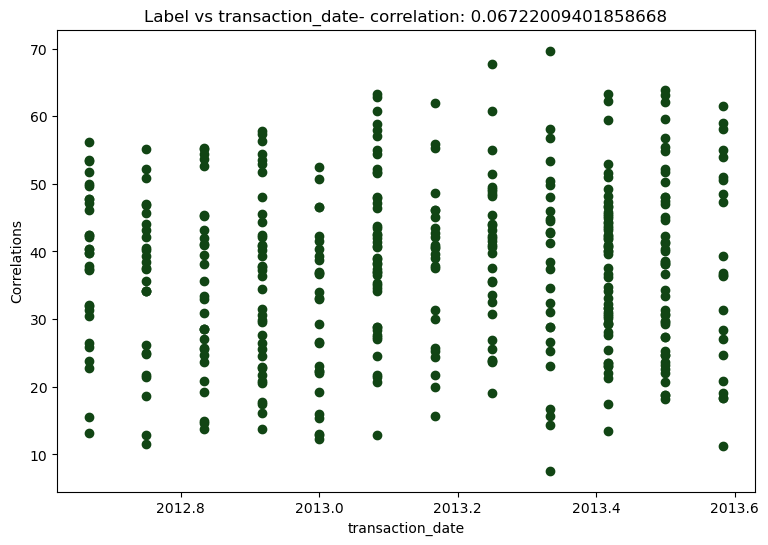

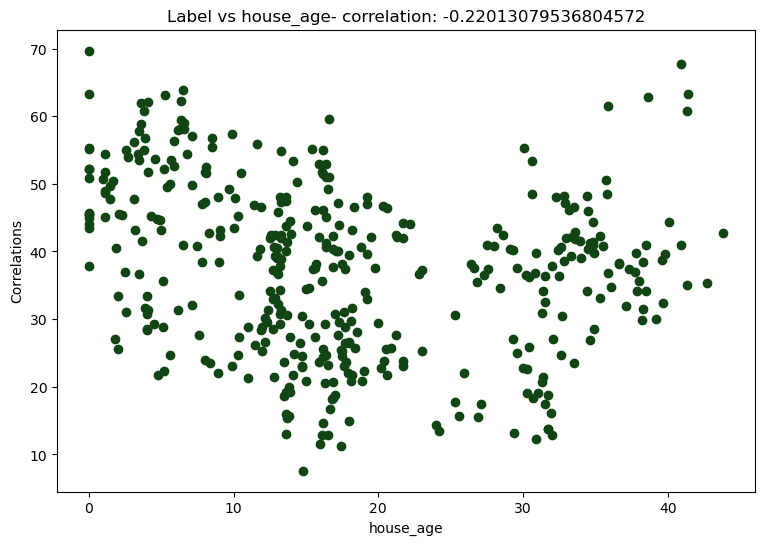

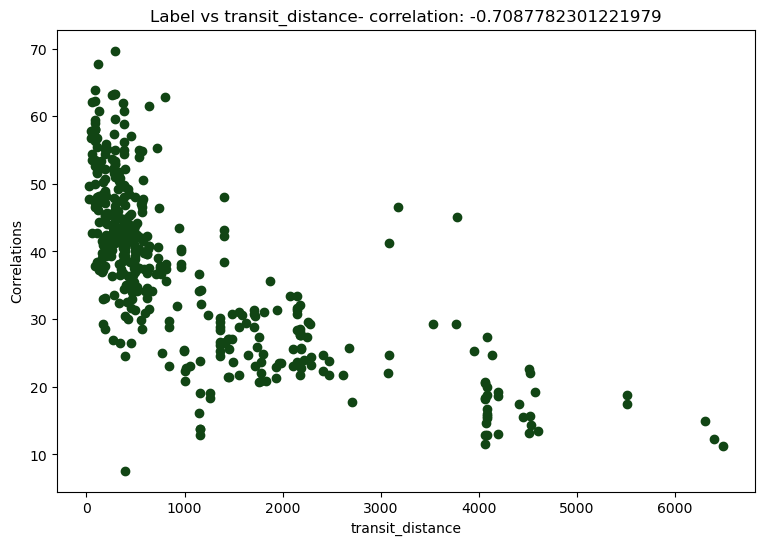

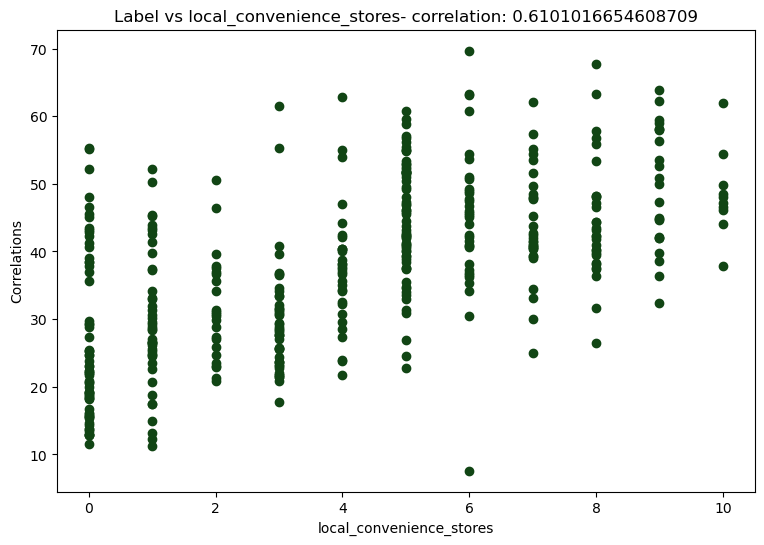

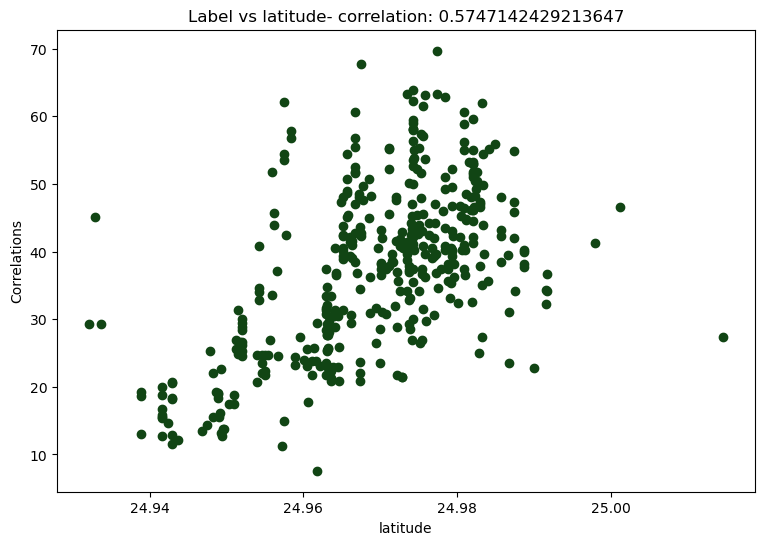

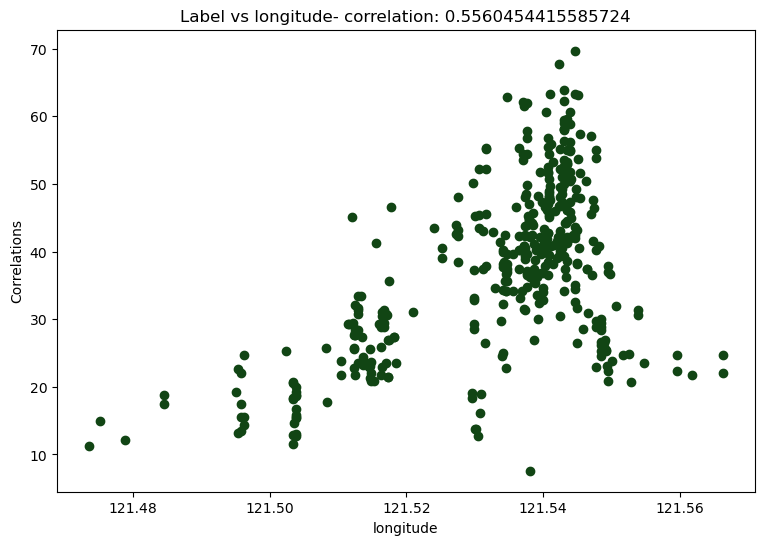

In [5]:
for col in df[df.columns[0:-1]]:
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca()
    feature = df[col]
    correlation = feature.corr(label)
    plt.scatter(x = feature, y = label, color = "#114514")
    plt.xlabel(col)
    plt.ylabel("Correlations")
    ax.set_title("Label vs " + col + "- correlation: " + str(correlation))
plt.show()    

### Kategorik değişkenler
(**transaction_date** ve **local_convenience_stores** ayrı değerler gibi görünüyor, bu nedenle kategorik özellikler olarak ele alınırsa daha iyi çalışabilir)

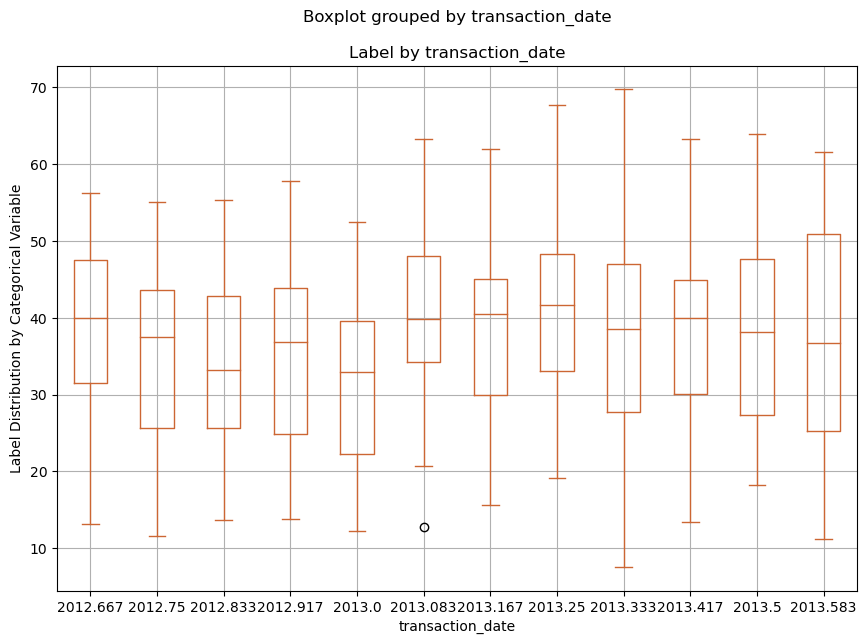

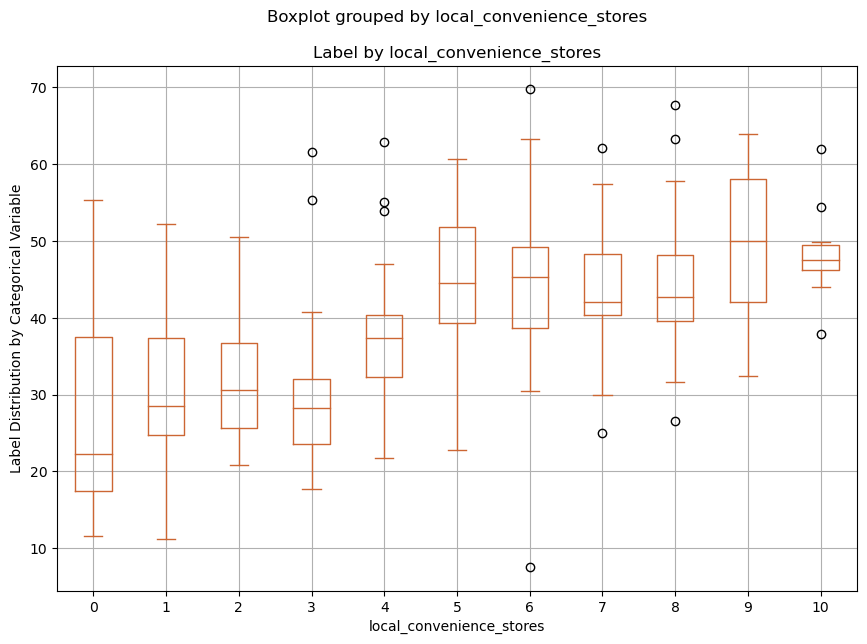

In [6]:
for col in df[["transaction_date", "local_convenience_stores"]]:
    fig = plt.figure(figsize=(10,7))
    ax = fig.gca()
    df.boxplot(column="price_per_unit", by=col, ax=ax, color="#cc6633")
    ax.set_title("Label by " + col)
    ax.set_ylabel("Label Distribution by Categorical Variable")
plt.show() 

### Eğitim ve doğrulama için etiket ve bölünmüş veriler
(**transaction_dat**e çok tahmin edici görünmüyor, bu yüzden onu atlayın)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X, y = df[df.columns[1:-1]].values, df[df.columns[-1]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print(f"Training Set: {X_train.shape[0]} rows\nTest Set: {X_test.shape[0]} rows")

Training Set: 285 rows
Test Set: 123 rows


### Verileri ön işleme ve model eğitme

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

In [10]:
numeric_features = [0, 1, 3, 4]
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
# numeric_transformer: Sayısal özellikler için kullanılacak dönüştürme işlemlerini içeren bir Pipeline nesnesidir. 
# Bu durumda, StandardScaler() kullanılarak özelliklerin standartlaştırılması 
# (özelliklerin ortalaması sıfır ve standart sapması bir olacak şekilde) yapılır.

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features)])
# ColumnTransformer: Farklı sütunlara farklı dönüştürme işlemleri uygulamak için kullanılan bir sınıftır. 
# num olarak adlandırılan sayısal dönüştürücü ile numeric_features listesinde belirtilen sütunlara 
# numeric_transformer'ı uygulayacaktır.

pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("regressor", RandomForestRegressor())])
# pipeline: Eğitim verilerini işlemek ve ardından RandomForestRegressor() kullanarak eğitim yapmak için kullanılan 
# bir Pipeline nesnesidir. İlk olarak preprocessor kullanılarak sayısal özelliklerin işlenmesi ve ardından 
# RandomForestRegressor() kullanılarak rastgele orman regresyon modelinin eğitilmesi yapılır.

model = pipeline.fit(X_train, (y_train))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 3, 4])])),
                ('regressor', RandomForestRegressor())])


### Modeli değerlendirme

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

MSE:  37.20700899650691
RMSE:  6.099754830852377
R2:  0.6825109116219765


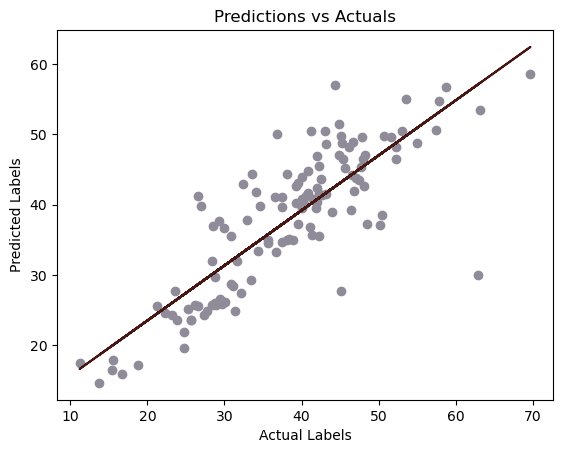

In [13]:
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE: ", mse)

rmse = np.sqrt(mse)
print("RMSE: ", rmse)

r2 = r2_score(y_test, predictions)
print("R2: ", r2)

plt.scatter(y_test, predictions, color = "#8f8b99")
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predictions vs Actuals')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color = "#461713")
plt.show()

### Eğitilmiş Modeli Kullanalım

In [19]:
X_new = np.array([[16.2,289.3248,5,24.98203,121.54348],
                  [13.6,4082.015,0,24.94155,121.5038]])

results = model.predict(X_new)
print("Predictions: ")
for prediction in results:
    print(round(prediction, 2))

Predictions: 
48.71
16.49
